In [1]:
import itertools
from typing import Callable, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym

import time

In [2]:
def mean_evol(Arr: np.ndarray) -> np.ndarray:
    """
    Suaviza la curva de aprendizaje o de recompensa.
    Args:
        Arr: array a suavizar
    """

    eps_val = np.linspace(1, len(Arr) + 1, len(Arr) + 1)
    cum_vals = np.cumsum(Arr)

    val_per_eps = [cum_vals[i] / eps_val[i] for i in range(len(cum_vals))]

    return np.array(val_per_eps)

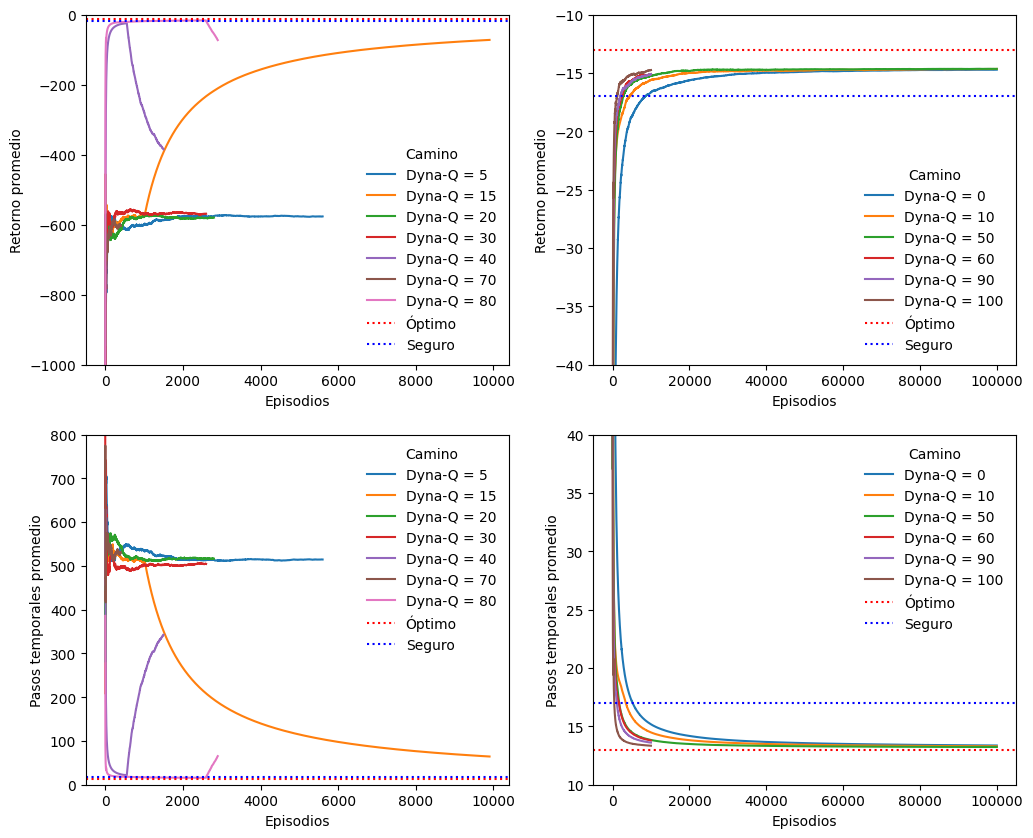

In [3]:
fig, axs = plt.subplots(2, 2,figsize=(12, 10))

for p_s in [5, 15, 20, 30, 40, 70, 80]:#, 90, 100]

    File = pd.read_csv(f'Outputs/Lab1/tmp_s-{p_s}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 0].plot(mean_evol(File[:,0]), label=rf'Dyna-Q = {p_s}')
    axs[1, 0].plot(mean_evol(File[:,1]), label=rf'Dyna-Q = {p_s}')

for p_s in [0, 10, 50, 60, 90, 100]:

    File = pd.read_csv(f'Outputs/Lab1/tmp_s-{p_s}.csv', header=None, sep='\t').iloc[201:, :2].to_numpy().astype(int)

    axs[0, 1].plot(mean_evol(File[:,0]), label=rf'Dyna-Q = {p_s}')
    axs[1, 1].plot(mean_evol(File[:,1]), label=rf'Dyna-Q = {p_s}')

axs[0, 0].set_ylim(-1000, 0)
axs[1, 0].set_ylim(0, 800)

axs[0, 1].set_ylim(-40, -10)
axs[1, 1].set_ylim(10, 40)

for k in range(2):
    axs[0, k].axhline(-13, color='red', linestyle=':', label='Óptimo')
    axs[0, k].axhline(-17, color='blue', linestyle=':', label='Seguro')
    axs[0, k].legend(loc='lower right', frameon=False, fancybox=True, title='Camino')

    axs[0, k].set_xlabel('Episodios')
    axs[0, k].set_ylabel('Retorno promedio')

    axs[1, k].axhline(13, color='red', linestyle=':', label='Óptimo')
    axs[1, k].axhline(17, color='blue', linestyle=':', label='Seguro')
    axs[1, k].legend(loc='upper right', frameon=False, fancybox=True, title='Camino')

    axs[1, k].set_xlabel('Episodios')
    axs[1, k].set_ylabel('Pasos temporales promedio')

plt.savefig('Outputs/Lab1/DynaQ/DynaQ-epGreedy_its-2000_eps-10000_a-0.05_g-0.65_e-0.005.png')